# Potato Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

### Import all the Dependencies

In [33]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [38]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

download the dataset from the above kaggle to the local computer.  

In [42]:
import os

In [44]:
os.chdir('path_dataset')

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [48]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plant_P",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [50]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [52]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

### Visualize some of the images from our dataset

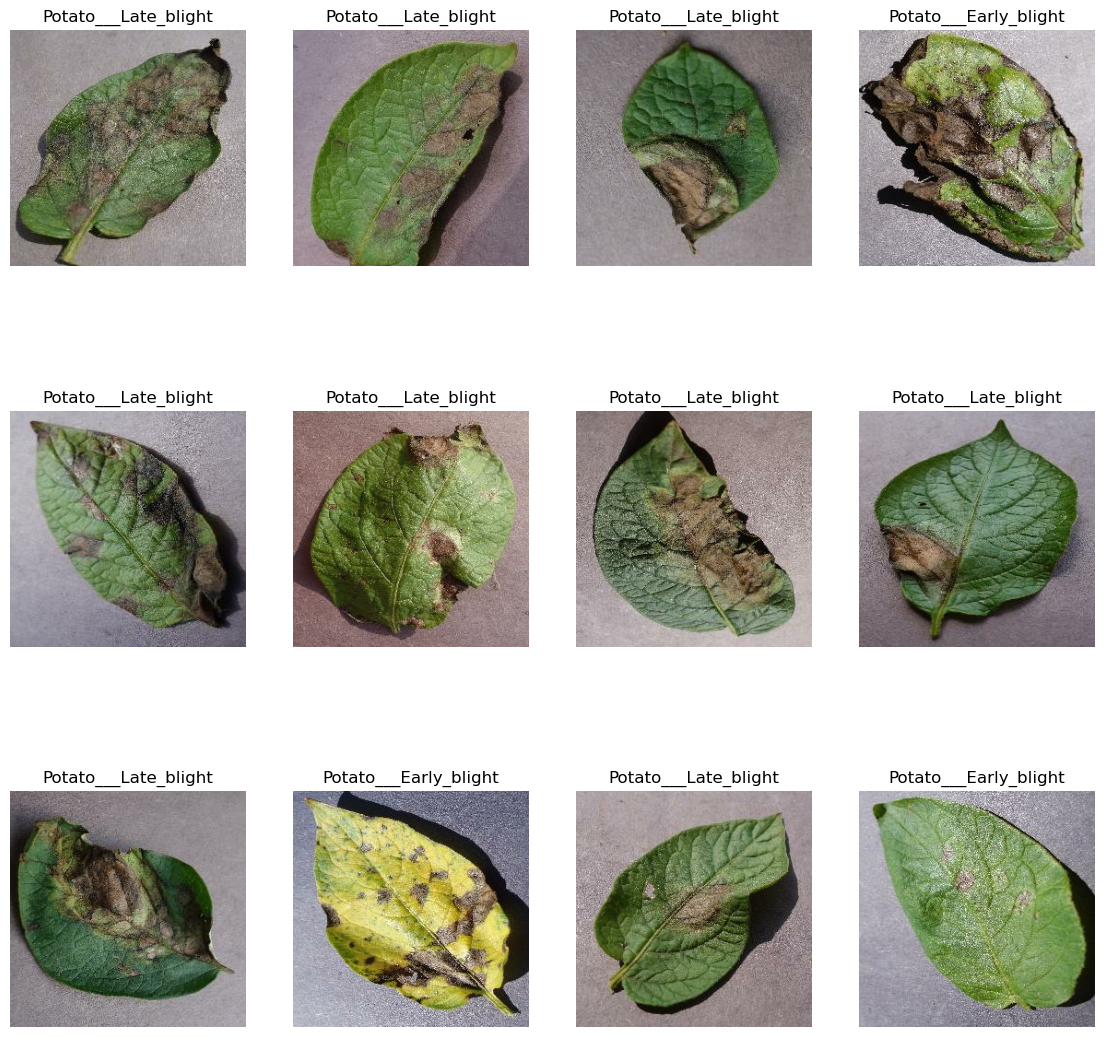

In [93]:
plt.figure(figsize=(14, 14))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [119]:
# data partition into train, validation and  test.  
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1    
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [121]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [123]:
len(train_ds)

54

In [125]:
len(val_ds)

6

In [127]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset

In [130]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [134]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [137]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [140]:
# Augmentation is applied only to training data. Not required for validation and testing
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [143]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [145]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [147]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [149]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 24s 430ms/step - loss: 0.8488 - accuracy: 0.5700 - val_loss: 0.8193 - val_accuracy: 0.5625
Epoch 2/10
54/54 [==============================] - 23s 421ms/step - loss: 0.5767 - accuracy: 0.7205 - val_loss: 0.9096 - val_accuracy: 0.6302
Epoch 3/10
54/54 [==============================] - 23s 422ms/step - loss: 0.3360 - accuracy: 0.8623 - val_loss: 0.4673 - val_accuracy: 0.8438
Epoch 4/10
54/54 [==============================] - 23s 423ms/step - loss: 0.2534 - accuracy: 0.9010 - val_loss: 0.2179 - val_accuracy: 0.9219
Epoch 5/10
54/54 [==============================] - 23s 421ms/step - loss: 0.2323 - accuracy: 0.9132 - val_loss: 0.3227 - val_accuracy: 0.8854
Epoch 6/10
54/54 [==============================] - 23s 423ms/step - loss: 0.2039 - accuracy: 0.9271 - val_loss: 0.2158 - val_accuracy: 0.9167
Epoch 7/10
54/54 [==============================] - 23s 423ms/step - loss: 0.1599 - accuracy: 0.9398 - val_loss: 0.1930 - val_accuracy: 0.9219

In [152]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 116ms/step - loss: 0.1410 - accuracy: 0.9297


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [154]:
scores

[0.14101102948188782, 0.9296875]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [158]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [162]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [164]:
type(history.history['loss'])

list

In [166]:
len(history.history['loss'])

10

In [168]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8488306999206543,
 0.5767451524734497,
 0.33601346611976624,
 0.25335174798965454,
 0.23227842152118683]

In [172]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [174]:
len(range(EPOCHS))

50

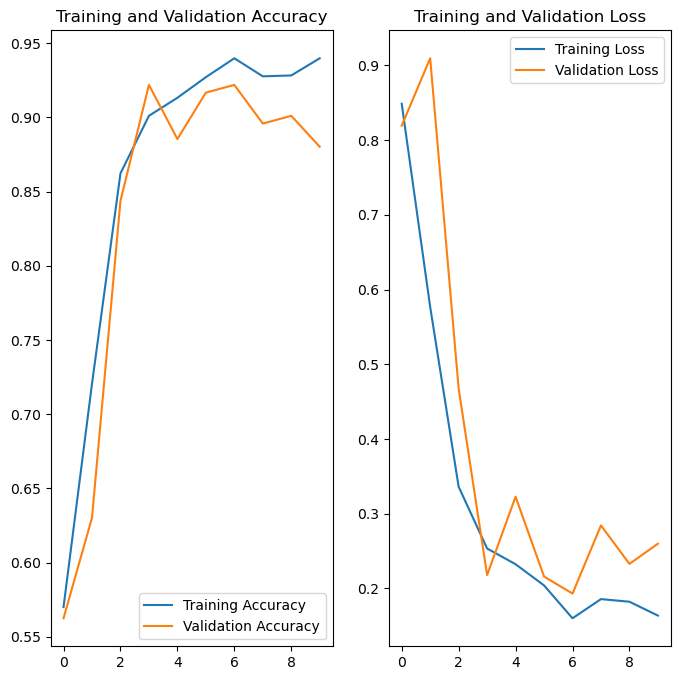

In [190]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS)[:10], acc, label='Training Accuracy')
plt.plot(range(EPOCHS)[:10], val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS)[:10], loss, label='Training Loss')
plt.plot(range(EPOCHS)[:10], val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

By hyper parameters tuning one can increae the train and test accuracies. 

### Run prediction on a sample image

In [192]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 178ms/step
predicted label: Potato___Early_blight


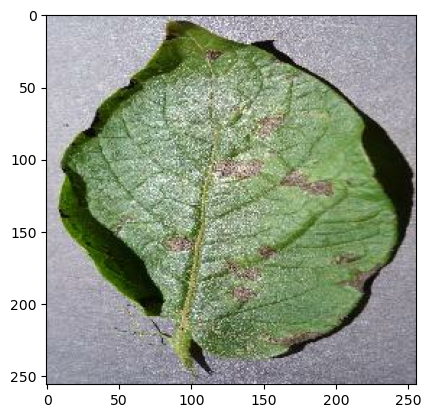

In [194]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):   # batch-1
    
    first_image = images_batch[0].numpy().astype('uint8')  # its the first image
    first_label = labels_batch[0].numpy()     # first image corresponding label
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [202]:
class_names[np.argmax(batch_prediction[0])]

'Potato___Early_blight'

### Write a function for inference

In [204]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 13ms/step


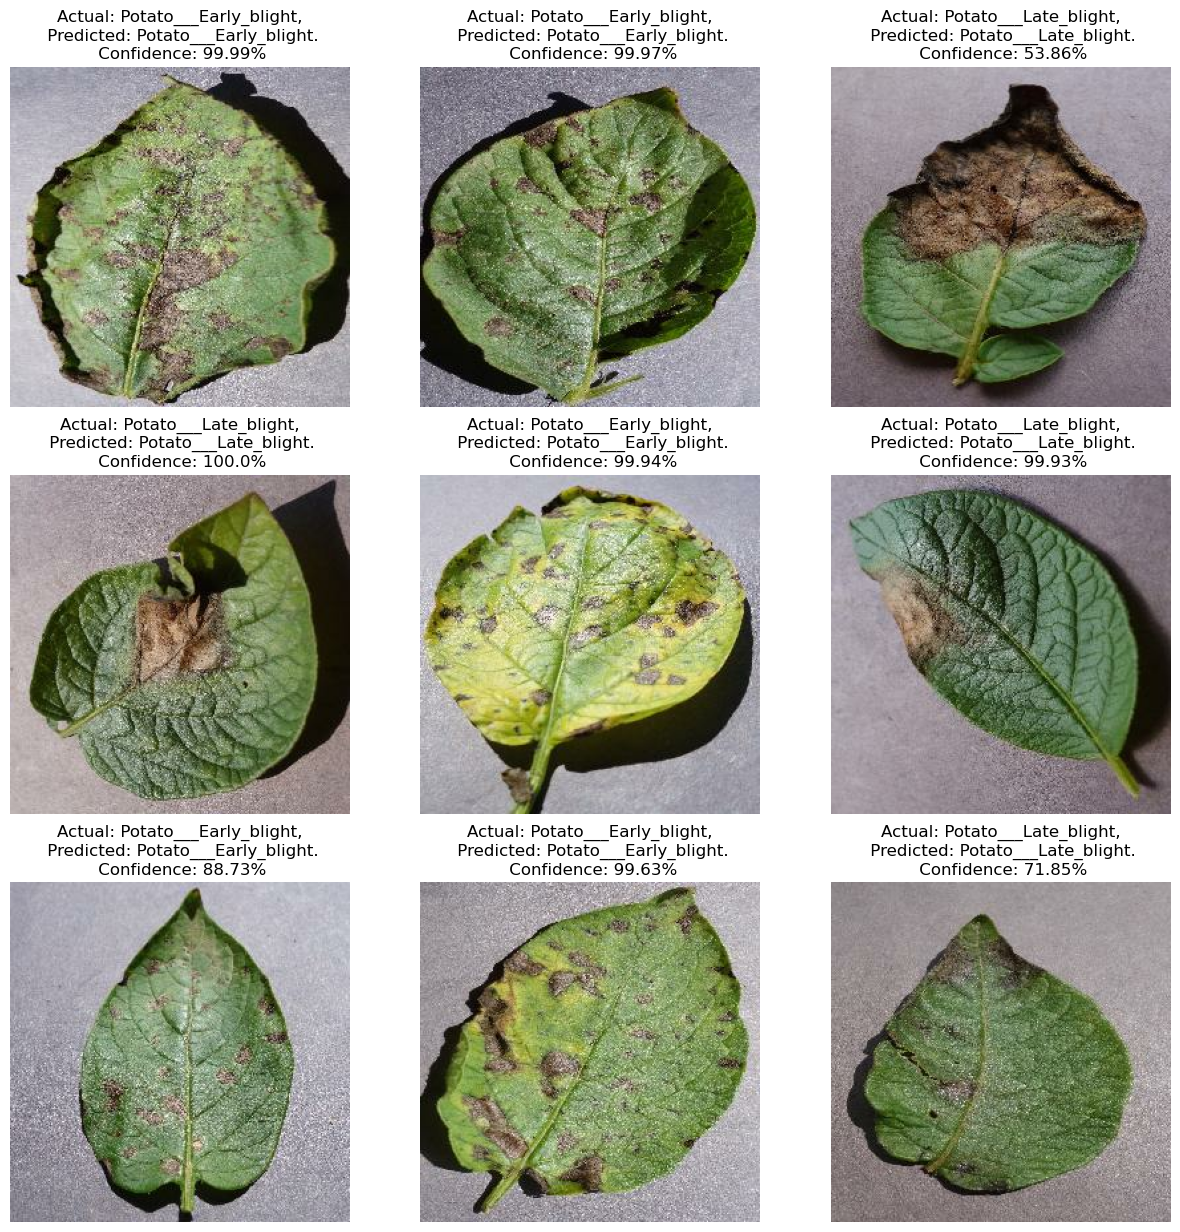

In [209]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [217]:
model.save("../potatoes.h5")  # Save the model

/opt/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Load the model

In [223]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [225]:
from keras.preprocessing import image
import numpy as np

In [227]:
import tensorflow as tf

from keras.models import load_model

In [237]:
model1=load_model('potatoes.h5')

In [247]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


(-0.5, 255.5, 255.5, -0.5)

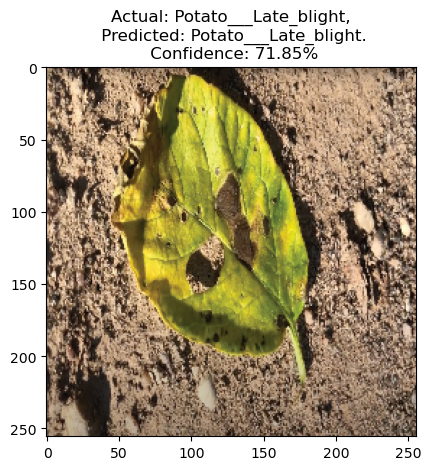

In [265]:
# predict(model1,im1)
plt.imshow(im1)  
predicted_class, confidence = predict(model1, im1)
actual_class = class_names[labels[i]] 

plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

plt.axis()